# CNN - Example 03

In [ ]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense

## Load Tensorflow Dataset (tfds)

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [ ]:
# Import TensorFlow Datasets
import tensorflow_datasets as tfds

In [ ]:
tfds.disable_progress_bar()

In [ ]:
import logging

In [ ]:
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

### Get train/test dataset

In [ ]:
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteVRH7NO/fashion_mnist-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteVRH7NO/fashion_mnist-test.tfrecord
Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
train_dataset, test_dataset = dataset['train'], dataset['test']

In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [ ]:
def get_name(id):
    return class_names[id]

In [ ]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples:     {}".format(num_test_examples))

Number of training examples: 60000
Number of test examples:     10000


In [ ]:
tfds.as_dataframe(train_dataset.take(5), metadata)

,image,label
0,,2 (Pullover)
1,,1 (Trouser)
2,,8 (Bag)
3,,4 (Coat)
4,,1 (Trouser)


### Normalize

# Preprocess the data

The value of each pixel in the image data is an integer in the range `[0,255]`.
For the model to work properly, these values need to be normalized to the range `[0,1]`.
So here we create a normalization function, and then apply it to each image in the test and train datasets.

In [ ]:
def normalize(images, labels):
    images = tf.cast(images, tf.float32)
    images /= 255
    return images, labels

# The map function applies the normalize function to each element in the train
# and test datasets
train_dataset = train_dataset.map(normalize)
test_dataset = test_dataset.map(normalize)

The first time you use the dataset, the images will be loaded from disk
Caching will keep them in memory, making training faster. Moving cache below
train_dataset = train_dataset.cache()
test_dataset = test_dataset.cache()

### Explore the data

Coat


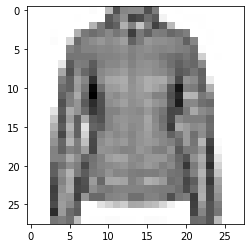

In [ ]:
# Take a single image, and remove the color dimension by reshaping
for image, label in test_dataset.take(1):
    break
image = image.numpy().reshape((28, 28))
plt.imshow(image, cmap=plt.cm.binary)
print(get_name(label))

Display the first 25 images from the *training set* and display the class name below each image. Verify that the
data is in the correct format and we're ready to build and train the network.

### Display few images

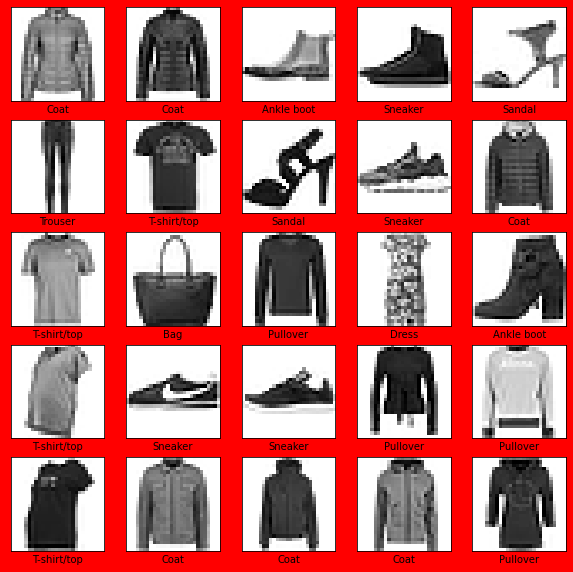

In [ ]:
plt.figure(figsize=(10, 10), facecolor="red")
i = 0
for (image, label) in test_dataset.take(25):
    image = image.numpy().reshape((28, 28))
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(class_names[label])
    i += 1
plt.show()

## Model # 1

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu, input_shape=(28, 28, 1)))
model.add(MaxPooling2D((2, 2), strides=2))
model.add(Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu))
model.add(MaxPooling2D((2, 2), strides=2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               401536    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1

Loss function — An algorithm for measuring how far the model's outputs are from the desired output. The goal of
training is this measures loss. Optimizer —An algorithm for adjusting the inner parameters of the model in order to
minimize loss. Metrics —Used to monitor the training and testing steps. The following example uses accuracy,
the fraction of the images that are correctly classified.

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

### Train the model

First, we define the iteration behavior for the train dataset: 1. Repeat forever by specifying `dataset.repeat()`
2. The `dataset.shuffle(60000)` randomizes the order so our model cannot learn anything from the order of the
examples. 3. And `dataset.batch(32)` tells `model.fit` to use batches of 32 images and labels when updating the
model variables. 4. The `epochs=5` parameter limits training to 5 full iterations of the training dataset,
so a total of 5 * 60000 = 300000 examples.

(Don't worry about `steps_per_epoch`, the requirement to have this flag will soon be removed.)

#### Normalize, Cache, Repeat, Shuffle Batch and Prefetch.

In [ ]:
BATCH_SIZE = 32
#AUTOTUNE = tensorflow.core.experimental.AUTOTUNE
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.map(normalize).cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_dataset = test_dataset.map(normalize).batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)

In [ ]:
history = model.fit(train_dataset, epochs = 100, steps_per_epoch=math.ceil(num_train_examples / BATCH_SIZE))

Epoch 1/100
1875/1875 [==============================] - 44s 6ms/step - loss: 0.5320 - accuracy: 0.8085
Epoch 2/100
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2845 - accuracy: 0.8967
Epoch 3/100
1875/1875 [==============================] - 10s 6ms/step - loss: 0.2210 - accuracy: 0.9199
Epoch 4/100
1875/1875 [==============================] - 10s 6ms/step - loss: 0.2006 - accuracy: 0.9254
Epoch 5/100
1875/1875 [==============================] - 10s 6ms/step - loss: 0.1660 - accuracy: 0.9385
Epoch 6/100
1875/1875 [==============================] - 10s 6ms/step - loss: 0.1420 - accuracy: 0.9485
Epoch 7/100
1875/1875 [==============================] - 11s 6ms/step - loss: 0.1202 - accuracy: 0.9547
Epoch 8/100
1875/1875 [==============================] - 10s 6ms/step - loss: 0.1055 - accuracy: 0.9602
Epoch 9/100
1875/1875 [==============================] - 10s 6ms/step - loss: 0.0853 - accuracy: 0.9700
Epoch 10/100
1875/1875 [==============================] - 10s 6m

### Save the trained model

In [ ]:
model_filename = "colab_model/02_fashion_mnist_tfds_model"

In [ ]:
model.save(model_filename)

In [ ]:
print(tf.__version__)

2.4.1


In [ ]:
!ls

colab_model  drive  sample_data


In [ ]:
!cp -r colab_model/02_fashion_mnist_tfds_model /content/drive/MyDrive/ColabModels/

### Evaluate

#### Eval - Train

In [ ]:
model.metrics_names

['loss', 'accuracy']

In [ ]:
pd.DataFrame(history.history).head(10)

,loss,accuracy
0,0.413486,0.850917
1,0.263639,0.904267
2,0.217258,0.919200
3,0.185276,0.932283
4,0.158623,0.941700
5,0.134851,0.950400
6,0.112667,0.957933
7,0.097638,0.963933
8,0.082853,0.970050
9,0.069150,0.974833


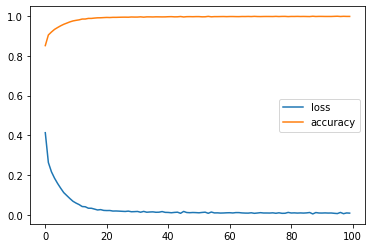

In [ ]:
pd.DataFrame(history.history).plot()

In [ ]:
losses = pd.DataFrame(history.history)

In [ ]:
print(losses)

        loss  accuracy
0   0.413486  0.850917
1   0.263639  0.904267
2   0.217258  0.919200
3   0.185276  0.932283
4   0.158623  0.941700
..       ...       ...
95  0.007361  0.998400
96  0.012991  0.997133
97  0.006799  0.998017
98  0.010506  0.997567
99  0.009541  0.997500

[100 rows x 2 columns]


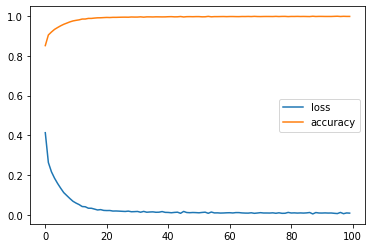

In [ ]:
losses[['loss', 'accuracy']].plot()

#### Eval - Test

In [ ]:
new_model = tf.keras.models.load_model(saved_model_filename)
new_model.summary()
test_loss, test_accuracy = new_model.evaluate(test_dataset, steps=math.ceil(num_test_examples / 32))

In [ ]:
print('Loss on test dataset:', test_loss)
print('Accuracy on test dataset:', test_accuracy)

Loss on test dataset: 1.3593275547027588
Accuracy on test dataset: 0.9154999852180481


As it turns out, the accuracy on the test dataset is smaller than the accuracy on the training dataset. 
This is completely normal, since the model was trained on the `train_dataset`. 
When the model sees images it has never seen during training, (that is, from the `test_dataset`), 
we can expect performance to go down. 

In [ ]:
print("Loss and Accuracy on Train dataset:")

Loss and Accuracy on Train dataset:


In [ ]:
pd.DataFrame(history.history).tail()

,loss,accuracy
95,0.007361,0.998400
96,0.012991,0.997133
97,0.006799,0.998017
98,0.010506,0.997567
99,0.009541,0.997500


### Predictions

In [ ]:
print(len(test_dataset) / BATCH_SIZE)

9.78125


In [ ]:
for test_images, test_labels in test_dataset.take(1):
    x_test = test_images.numpy()
    y_test = test_labels.numpy()

In [ ]:
y_prediction = np.argmax(new_model.predict(x_test), axis=-1)

In [ ]:
print(len(y_test))

32


In [ ]:
print(len(y_prediction))

32


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
print(classification_report(y_test, y_prediction))
print(confusion_matrix(y_test, y_prediction))

              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      1.00      1.00         1
           2       1.00      0.80      0.89         5
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         8
           5       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         7
           8       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         2

    accuracy                           0.97        32
   macro avg       0.98      0.98      0.98        32
weighted avg       0.97      0.97      0.97        32

[[4 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0]
 [1 0 4 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0]
 [0 0 0 0 8 0 0 0 0]
 [0 0 0 0 0 3 0 0 0]
 [0 0 0 0 0 0 7 0 0]
 [0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 2]]


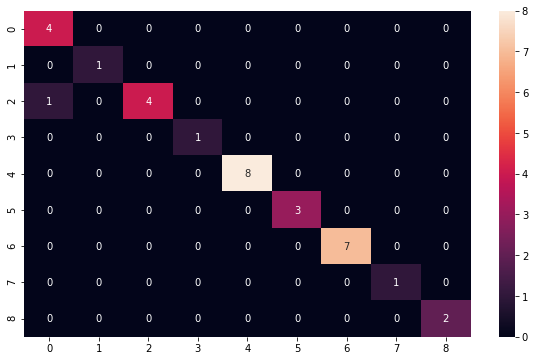

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_prediction), annot=True)

### Predictions go wrong!

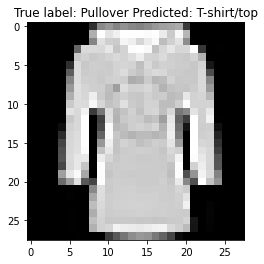

In [ ]:
# Show some misclassified examples
misclassified_idx = np.where(y_prediction != y_test)[0]
i = np.random.choice(misclassified_idx)
plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
# plt.title("True label: %s Predicted: %s" % (y_test[i], y_prediction[i]));
t = get_name(y_test[i])
p = get_name(y_prediction[i])
plt.title("True label: %s Predicted: %s" % (t, p));

In [ ]:
print("Percentage of wrong predications : " + str(len(misclassified_idx) / len(y_prediction) * 100) + " %")
print("Models maximum accuracy            : " + str(np.max(history.history['accuracy']) * 100) + " %")
# print("Models maximum validation accuracy : " + str(np.max(history.history['val_accuracy'])*100) + " %")

Percentage of wrong predications : 3.125 %
Models maximum accuracy            : 99.83999729156494 %


### Additonal Files(s) to test the model

In [ ]:
# Grab an image from the test dataset
img = test_images[0]

In [ ]:
print(img.shape)

(28, 28, 1)


In [ ]:
img = np.array([img])

In [ ]:
print(img.shape)

(1, 28, 28, 1)


In [ ]:
predictions_single = new_model.predict(img)

In [ ]:
print(predictions_single)

[[6.2822927e-36 0.0000000e+00 1.1262141e-16 0.0000000e+00 1.0000000e+00
  0.0000000e+00 2.4346427e-17 0.0000000e+00 0.0000000e+00 0.0000000e+00]]


In [ ]:
np.argmax(predictions_single[0])

4

### Exercises

Experiment with different models and see how the accuracy results differ. In particular change the following
parameters: *   Set training epochs set to 1 *   Number of neurons in the Dense layer following the Flatten one.
For example, go really low (e.g. 10) in ranges up to 512 and see how accuracy changes *   Add additional Dense
layers between the Flatten and the final Dense(10), experiment with different units in these layers *   Don't
normalize the pixel values, and see the effect that has


Remember to enable GPU to make everything run faster (Runtime -> Change runtime type -> Hardware accelerator -> GPU).
Also, if you run into trouble, simply reset the entire environment and start from the beginning:
*   Edit -> Clear all outputs
*   Runtime -> Reset all runtimes